<a href="https://colab.research.google.com/github/iwatsuki-yuuki/college/blob/main/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E6%BC%94%E7%BF%92_08D22015_%E5%B2%A9%E6%9C%88%E5%84%AA%E6%A8%B9%EF%BC%88%E8%AA%B2%E9%A1%8C3%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
!pip install optuna

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# pandasとtensorflowのインストール（必要に応じて）
!pip install pandas tensorflow scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import random as random
import os
import sys
import copy

In [ ]:
#乱数の固定化

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
# Compasデータセットのダウンロード
!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

# pandasでデータを読み込む
data = pd.read_csv("compas-scores-two-years.csv")

# データの最初の5行を表示して確認
print(data.head())


--2025-05-18 18:07:27--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv.4’

compas-scores-two-y 100%[===================>]   2.43M  --.-KB/s    in 0.06s   

2025-05-18 18:07:27 (40.4 MB/s) - ‘compas-scores-two-years.csv.4’ saved [2546489/2546489]

   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        br

In [ ]:
# データ（特徴量）をPandasのデータフレームに変換
df_data = data
# ターゲット（ラベル）を別に保存
target = data['two_year_recid']

#NaNを含むColumn名
nan_columns = df_data.columns[df_data.isnull().any()].tolist()
print("NaNを含む列:", nan_columns)


#欠損値がある行を削除
df_data = data.dropna()
# 不要な列を削除（例：idなど）
df_data = data.drop(columns=['id', 'first','last','start','end','event'], axis=1)
df_data = df_data.drop(nan_columns, axis=1)


df_encoded = pd.get_dummies(df_data)

# ターゲット（ラベル）をOne-Hot Encoding後のデータフレームに追加
df_encoded['target'] = target

# 特徴量とターゲットを定義
X = df_encoded.drop(['two_year_recid','is_recid','is_violent_recid','target'], axis=1)
y = df_encoded['target']

# 特徴量選択（上位20個のみ使用）
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=30)
X = selector.fit_transform(X, y)


NaNを含む列: ['days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_desc', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'in_custody', 'out_custody']


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [13322 14016] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
# 訓練セットとテストセットに分割
# (課題1)50％をテストデータとして分けた
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,test_size=0.5, random_state=42)

# 残り50%から25%を検証データにする（全体の15%）
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.50, random_state=42)

# データの標準化

scaler = StandardScaler()

# 訓練データに対して平均と標準偏差を計算し、それで変換する
X_train = scaler.fit_transform(X_train)
# 訓練データで計算した基準（平均.標準偏差）を使って検証データとテストデータも同じように整える
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# NumPy配列からPyTorchのテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # 二値分類の場合、ラベルはlong型


In [ ]:
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)


X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
class CompasDataset:
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
batch_size = 128
train_dataset = CompasDataset(X_train_tensor, y_train_tensor)
val_dataset = CompasDataset(X_val_tensor, y_val_tensor)
test_dataset = CompasDataset(X_test_tensor, y_test_tensor)
# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_dataset)

In [ ]:
class CompasDataset:
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels  # Assign labels directly instead of calling .values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx] # Access elements using indexing

In [ ]:
length = X.shape[1]
print(length)

30


In [ ]:
# デバイスの設定
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# ニューラルネットワークの定義
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)


# Optuna の目的関数
def objective(trial):
    model = SimpleNN(input_size=X_train.shape[1]).to(device)

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(5):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(X_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()

    # 検証精度を評価
    model.eval()
    correct = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch)
            correct += (pred.argmax(1) == y_batch).sum().item()

    accuracy = correct / len(val_loader.dataset)
    return accuracy

# Optunaの最適化実行
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# 最良のパラメータでモデル再構成
best_params = study.best_params
best_model = SimpleNN(input_size=X_train.shape[1]).to(device)
optimizer = getattr(torch.optim, best_params['optimizer'])(best_model.parameters(), lr=best_params['lr'])


[I 2025-05-18 18:07:31,878] A new study created in memory with name: no-name-c2676adc-f8ff-40c9-acef-e82df6e135fe


Using cuda device


[I 2025-05-18 18:07:32,225] Trial 0 finished with value: 0.5698447893569845 and parameters: {'optimizer': 'SGD', 'lr': 0.00011642069660115304}. Best is trial 0 with value: 0.5698447893569845.
[I 2025-05-18 18:07:32,529] Trial 1 finished with value: 0.655210643015521 and parameters: {'optimizer': 'Adam', 'lr': 0.00017298895157807966}. Best is trial 1 with value: 0.655210643015521.
[I 2025-05-18 18:07:32,779] Trial 2 finished with value: 0.6541019955654102 and parameters: {'optimizer': 'SGD', 'lr': 0.009349432576408905}. Best is trial 1 with value: 0.655210643015521.
[I 2025-05-18 18:07:33,116] Trial 3 finished with value: 0.6590909090909091 and parameters: {'optimizer': 'Adam', 'lr': 0.0014823632314051938}. Best is trial 3 with value: 0.6590909090909091.
[I 2025-05-18 18:07:33,523] Trial 4 finished with value: 0.6657427937915743 and parameters: {'optimizer': 'Adam', 'lr': 0.008441545262255358}. Best is trial 4 with value: 0.6657427937915743.
[I 2025-05-18 18:07:33,941] Trial 5 finished 

In [ ]:
for name, param in best_model.named_parameters():
    print(f"{name}: mean={param.data.mean().item()}, std={param.data.std().item()}")

net.0.weight: mean=-0.0011611819500103593, std=0.10501782596111298
net.0.bias: mean=0.00946962833404541, std=0.10828668624162674
net.2.weight: mean=1.0, std=0.0
net.2.bias: mean=0.0, std=0.0
net.4.weight: mean=0.0009961110772565007, std=0.05106673389673233
net.4.bias: mean=0.0026716941501945257, std=0.05522052198648453
net.6.weight: mean=1.0, std=0.0
net.6.bias: mean=0.0, std=0.0
net.8.weight: mean=-0.015230748802423477, std=0.07888028770685196
net.8.bias: mean=-0.03428048640489578, std=0.01166954543441534


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# クラス重みを計算（再犯・非再犯のバランス対策）
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# 損失関数に重みを設定
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # 損失誤差を計算
        pred = model(X)
        #print(pred)
        loss = loss_fn(pred, y)

        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    avg_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            avg_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    avg_loss /= size
    accuracy /= size
    return avg_loss, accuracy


In [ ]:
epochs = 150
patience = 10
best_val_loss = float("inf")
patience_counter = 0

In [ ]:
best_model_state = None
best_val_loss = float("inf")
patience_counter = 0

for t in range(epochs):
    train(train_loader, best_model, loss_fn, optimizer)
    val_loss, val_accuracy = test(val_loader, best_model)

    print(f"Epoch {t}, Val Accuracy: {(100*val_accuracy):.2f}%, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(best_model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

# 最良モデルをロード
best_model.load_state_dict(best_model_state)

print("Done!")

# 未知のテストデータでモデル学習、最終的な精度と損失を表示します
test_loss, test_accuracy = test(test_loader, best_model)
print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Val loss: {test_loss:>8f} \n")


loss: 0.879643  [    0/ 1803]
loss: 0.607368  [ 1280/ 1803]
Epoch 0, Val Accuracy: 64.47%, Val Loss: 0.0053
loss: 0.635512  [    0/ 1803]
loss: 0.595669  [ 1280/ 1803]
Epoch 1, Val Accuracy: 66.02%, Val Loss: 0.0053
loss: 0.578812  [    0/ 1803]
loss: 0.628244  [ 1280/ 1803]
Epoch 2, Val Accuracy: 65.63%, Val Loss: 0.0053
loss: 0.597001  [    0/ 1803]
loss: 0.605274  [ 1280/ 1803]
Epoch 3, Val Accuracy: 65.08%, Val Loss: 0.0055
loss: 0.668882  [    0/ 1803]
loss: 0.558975  [ 1280/ 1803]
Epoch 4, Val Accuracy: 66.13%, Val Loss: 0.0054
loss: 0.530313  [    0/ 1803]
loss: 0.577581  [ 1280/ 1803]
Epoch 5, Val Accuracy: 65.02%, Val Loss: 0.0053
loss: 0.548978  [    0/ 1803]
loss: 0.576327  [ 1280/ 1803]
Epoch 6, Val Accuracy: 65.13%, Val Loss: 0.0054
loss: 0.547952  [    0/ 1803]
loss: 0.606080  [ 1280/ 1803]
Epoch 7, Val Accuracy: 65.96%, Val Loss: 0.0055
loss: 0.558466  [    0/ 1803]
loss: 0.585482  [ 1280/ 1803]
Epoch 8, Val Accuracy: 64.69%, Val Loss: 0.0054
loss: 0.571027  [    0/ 1803

In [ ]:
y_pred = best_model(X_test_tensor.to(device)).argmax(1)

              precision    recall  f1-score   support

           0      0.706     0.732     0.719      2012
           1      0.645     0.615     0.630      1595

    accuracy                          0.680      3607
   macro avg      0.676     0.674     0.674      3607
weighted avg      0.679     0.680     0.679      3607



<Axes: >

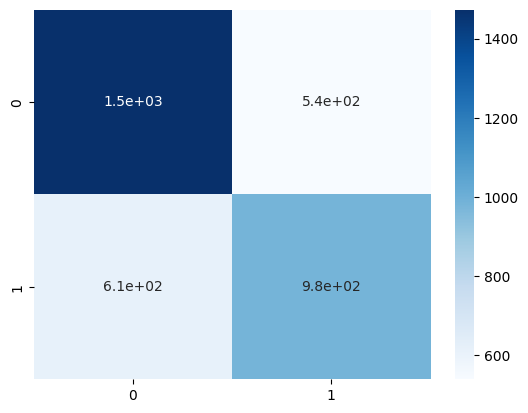

In [ ]:
# テスト用データで予測値を生成する

# テスト用データで予測した結果のclassfication_reportを表示する
from sklearn.metrics import classification_report

# classfication_reportを表示
print(classification_report(y_test_tensor.cpu(),y_pred.cpu(),digits=3))

# 混同行列を作成してseabornで表示する
from sklearn.metrics import confusion_matrix
import seaborn as sns
# 混同行列を表示
cm = confusion_matrix(y_test_tensor.cpu(),y_pred.cpu())
sns.heatmap(cm, annot=True, cmap='Blues')
